# Mobile Game Analytics: Player Behavior & Monetization Deep Dive

**Author:** Amir  
**Environment:** Google BigQuery + Python (GCP Colab)  
**Dataset:** 15M+ player events from a mobile game (Dec 2021 - Mar 2022)

---

## Executive Summary

This analysis examines player behavior, retention, and monetization patterns in a mobile game with approximately 26,000 users and 15 million event records. The key business questions addressed are:

1. **How well does the game retain players?** (Day 1, Day 7, Day 30 retention)
2. **What drives monetization?** (Conversion rates, windowed LTV, time-to-purchase)
3. **Where do players churn vs. convert?** (Level-based analysis)
4. **Are there significant differences between cohorts?** (Statistical validation with effect sizes)
5. **Can we segment players by behavior?** (Rule-based archetypes & conversion strategy)

### Key Findings (Preview)
- **Retention:** Day 1 retention averages ~35%, with significant variance across cohorts
- **Monetization:** 81% of first purchases occur at Level 1, with 1.68% overall payer conversion
- **Churn Hotspot:** Level 6 shows the highest churn concentration (23.5% of all churned users)
- **Statistical Insight:** January cohort shows higher LTV30 than February (with effect size and CI)
- **Segmentation:** Grinders show high engagement but zero spend — key conversion opportunity

---
## Part 1: Environment Setup & Data Overview

In [39]:
# Core libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical testing
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')

# BigQuery client
client = bigquery.Client()

# Table reference
TABLE = 'ppltx-ba-course.final_project.fact'

print("Environment ready.")


Environment ready.


In [40]:
# Helper function: Bootstrap confidence interval
def bootstrap_ci(data, statistic=np.mean, n_bootstrap=1000, ci=0.95):
    """
    Calculate bootstrap confidence interval for a statistic.
    Returns: (point_estimate, ci_lower, ci_upper)
    """
    data = np.array(data)
    boot_stats = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_stats.append(statistic(sample))

    point_est = statistic(data)
    alpha = 1 - ci
    ci_lower = np.percentile(boot_stats, alpha/2 * 100)
    ci_upper = np.percentile(boot_stats, (1 - alpha/2) * 100)

    return point_est, ci_lower, ci_upper

print("Helper functions loaded.")

Helper functions loaded.


### 1.1 Data Preview

Let's first examine the raw data structure and get a feel for what we're working with.

In [41]:
# Preview the data
query_preview = f"""
SELECT *
FROM `{TABLE}`
LIMIT 10000
"""

df_preview = client.query(query_preview).to_dataframe()

print("DATA PREVIEW")
print("="*60)
display(df_preview.head(10))

print("\nDATA INFO")
print("="*60)
print(df_preview.info())

print("\nSAMPLE SHAPE")
print("="*60)
print(f"Preview sample: {df_preview.shape[0]:,} rows × {df_preview.shape[1]} columns")

DATA PREVIEW


,uid,event,event_time,session_number,event_number,Level,Coins_Balance,Coins_Earned,price
0,ace4bec1,Steal_End,2022-01-04 04:00:35+00:00,1,6,1,1200,700,<NA>
1,c9d37cff,Steal_End,2022-02-04 05:11:58+00:00,2,63,2,22206,1820,<NA>
2,24f17f60,Collect_Chest,2022-01-18 00:12:35+00:00,2,48,2,16497,42,<NA>
3,051394c7,Collect_Chest,2022-01-03 03:01:00+00:00,1,10,1,1752,52,<NA>
4,9590a8e3,Collect_Chest,2022-01-04 07:01:04+00:00,1,13,1,938,4,<NA>
5,2d1a9c10,Collect_Chest,2022-01-12 16:04:42+00:00,2,27,1,3731,81,<NA>
6,e91e9882,Steal_End,2022-01-05 01:08:52+00:00,2,37,2,11460,700,<NA>
7,9b79f429,Collect_Chest,2022-02-11 13:13:07+00:00,2,67,2,13436,1,<NA>
8,da733ea9,InApp_Purchase_Canceled,2022-02-10 19:10:49+00:00,2,54,2,33654,15000,5
9,8e869b74,Steal_End,2022-01-07 03:02:09+00:00,2,22,1,2740,40,<NA>



DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   uid             10000 non-null  object             
 1   event           10000 non-null  object             
 2   event_time      10000 non-null  datetime64[us, UTC]
 3   session_number  10000 non-null  Int64              
 4   event_number    10000 non-null  Int64              
 5   Level           10000 non-null  Int64              
 6   Coins_Balance   9924 non-null   Int64              
 7   Coins_Earned    6502 non-null   Int64              
 8   price           86 non-null     Int64              
dtypes: Int64(6), datetime64[us, UTC](1), object(2)
memory usage: 761.8+ KB
None

SAMPLE SHAPE
Preview sample: 10,000 rows × 9 columns


### 1.2 Data Schema & Coverage

Now let's understand the full dataset: event types, date range, and scale.

In [42]:
# Data overview query
query_overview = f"""
SELECT
    COUNT(1) as total_events,
    COUNT(DISTINCT uid) as unique_users,
    MIN(DATE(event_time)) as first_date,
    MAX(DATE(event_time)) as last_date,
    COUNT(DISTINCT event) as event_types,
    COUNT(DISTINCT DATE(event_time)) as days_of_data
FROM `{TABLE}`
"""

df_overview = client.query(query_overview).to_dataframe()
print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Total Events:     {df_overview['total_events'].iloc[0]:,}")
print(f"Unique Users:     {df_overview['unique_users'].iloc[0]:,}")
print(f"Date Range:       {df_overview['first_date'].iloc[0]} to {df_overview['last_date'].iloc[0]}")
print(f"Days of Data:     {df_overview['days_of_data'].iloc[0]}")
print(f"Event Types:      {df_overview['event_types'].iloc[0]}")
print("=" * 50)

DATASET OVERVIEW
Total Events:     15,813,359
Unique Users:     26,576
Date Range:       2021-12-29 to 2025-09-13
Days of Data:     1197
Event Types:      18


In [43]:
# Event types breakdown
query_events = f"""
SELECT
    event,
    COUNT(1) as count,
    ROUND(COUNT(1) * 100.0 / SUM(COUNT(1)) OVER(), 2) as pct
FROM `{TABLE}`
GROUP BY 1
ORDER BY 2 DESC
"""

df_events = client.query(query_events).to_dataframe()
df_events

,event,count,pct
0,Play,8133015,51.43
1,Store_Close,875339,5.54
2,Store_Open,875339,5.54
3,Attack_Start,625073,3.95
4,Attack_End,625073,3.95
5,Popup_Open,624859,3.95
6,Popup_Close,624859,3.95
7,Collect_Chest,500776,3.17
8,Steal_Start,499717,3.16
9,Steal_End,499717,3.16


**Observation:** The dataset captures the full player journey - from sessions and gameplay (`Play`, `Session_Start/End`) to social features (`Attack`, `Steal`, `Invite_Friend`) and monetization (`Store_Open/Close`, `InApp_Purchase`). The `Play` event dominates at ~52% of all events, which is expected for an action-oriented game.

### 1.3 Data Quality Validation

In [44]:
# Data quality checks
query_quality = f"""
SELECT
    -- Null checks
    COUNTIF(uid IS NULL) as null_uid,
    COUNTIF(event IS NULL) as null_event,
    COUNTIF(event_time IS NULL) as null_event_time,

    -- Event pair validation (Start/End matching)
    COUNTIF(event = 'Session_Start') as session_starts,
    COUNTIF(event = 'Session_End') as session_ends,
    COUNTIF(event = 'Store_Open') as store_opens,
    COUNTIF(event = 'Store_Close') as store_closes,

    -- Purchase validation
    COUNTIF(event = 'InApp_Purchase') as purchases,
    COUNTIF(event = 'InApp_Purchase_Canceled') as canceled

FROM `{TABLE}`
"""

df_quality = client.query(query_quality).to_dataframe()

print("DATA QUALITY REPORT")
print("-" * 40)
print(f"Null UIDs:          {df_quality['null_uid'].iloc[0]}")
print(f"Null Events:        {df_quality['null_event'].iloc[0]}")
print(f"Null Timestamps:    {df_quality['null_event_time'].iloc[0]}")
print("-" * 40)
print(f"Session Start/End:  {df_quality['session_starts'].iloc[0]:,} / {df_quality['session_ends'].iloc[0]:,}")
print(f"Store Open/Close:   {df_quality['store_opens'].iloc[0]:,} / {df_quality['store_closes'].iloc[0]:,}")
print(f"Purchases/Canceled: {df_quality['purchases'].iloc[0]:,} / {df_quality['canceled'].iloc[0]:,}")
print("-" * 40)
print("✓ Data quality is suitable for analysis")

DATA QUALITY REPORT
----------------------------------------
Null UIDs:          0
Null Events:        0
Null Timestamps:    0
----------------------------------------
Session Start/End:  309,482 / 306,518
Store Open/Close:   875,339 / 875,339
Purchases/Canceled: 2,496 / 122,280
----------------------------------------
✓ Data quality is suitable for analysis


---
## Part 2: User Acquisition & Engagement

Before diving into retention and monetization, let's understand the user base: when did users join, and how engaged are they?

### 2.1 Cohort Sizes

In [45]:
# Install cohorts
query_installs = f"""
WITH user_install AS (
    SELECT
        uid,
        DATE(MIN(event_time)) as install_date,
        DATE_TRUNC(DATE(MIN(event_time)), MONTH) as cohort_month
    FROM `{TABLE}`
    GROUP BY 1
)

SELECT
    cohort_month,
    COUNT(DISTINCT uid) as users,
    MIN(install_date) as first_install,
    MAX(install_date) as last_install
FROM user_install
GROUP BY 1
ORDER BY 1
"""

df_cohorts = client.query(query_installs).to_dataframe()
df_cohorts['pct'] = (df_cohorts['users'] / df_cohorts['users'].sum() * 100).round(1)

print("COHORT SIZES")
print(df_cohorts.to_string(index=False))
print(f"\nTotal Users: {df_cohorts['users'].sum():,}")

COHORT SIZES
cohort_month  users first_install last_install   pct
  2021-12-01    489    2021-12-29   2021-12-31  1.80
  2022-01-01  13804    2022-01-01   2022-01-31 51.90
  2022-02-01  10260    2022-02-01   2022-02-28 38.60
  2022-03-01   2023    2022-03-01   2022-03-08  7.60

Total Users: 26,576


### 2.2 Daily Installs

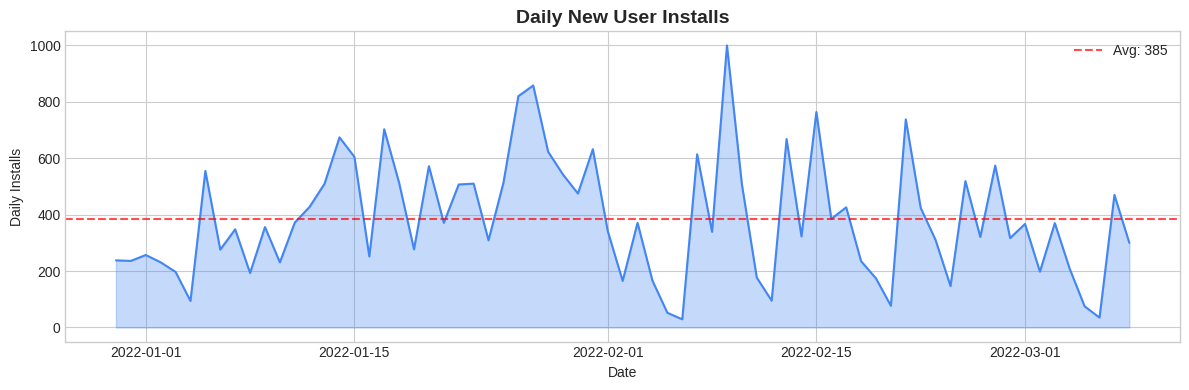

Average daily installs: 385
Peak day: 2022-02-09 (1000 installs)


In [46]:
# Daily installs - FIXED SQL
query_daily_installs = f"""
WITH user_installs AS (
    SELECT
        uid,
        DATE(MIN(event_time)) as install_date
    FROM `{TABLE}`
    GROUP BY uid
)
SELECT
    install_date,
    COUNT(*) as installs
FROM user_installs
WHERE install_date >= '2021-12-30'
GROUP BY install_date
ORDER BY install_date
"""

df_daily = client.query(query_daily_installs).to_dataframe()
df_daily['install_date'] = pd.to_datetime(df_daily['install_date'])

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_daily['install_date'], df_daily['installs'], color='#4285F4', linewidth=1.5)
ax.fill_between(df_daily['install_date'], df_daily['installs'], alpha=0.3, color='#4285F4')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Installs')
ax.set_title('Daily New User Installs', fontsize=14, fontweight='bold')
ax.axhline(y=df_daily['installs'].mean(), color='red', linestyle='--', alpha=0.7, label=f"Avg: {df_daily['installs'].mean():.0f}")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Average daily installs: {df_daily['installs'].mean():.0f}")
print(f"Peak day: {df_daily.loc[df_daily['installs'].idxmax(), 'install_date'].strftime('%Y-%m-%d')} ({df_daily['installs'].max()} installs)")

**Observation:** January 2022 represents the largest cohort (52% of users), likely indicating a user acquisition campaign or feature launch. The March cohort is notably smaller and incomplete, which we'll account for in retention calculations.

### 2.3 Engagement: DAU and Stickiness

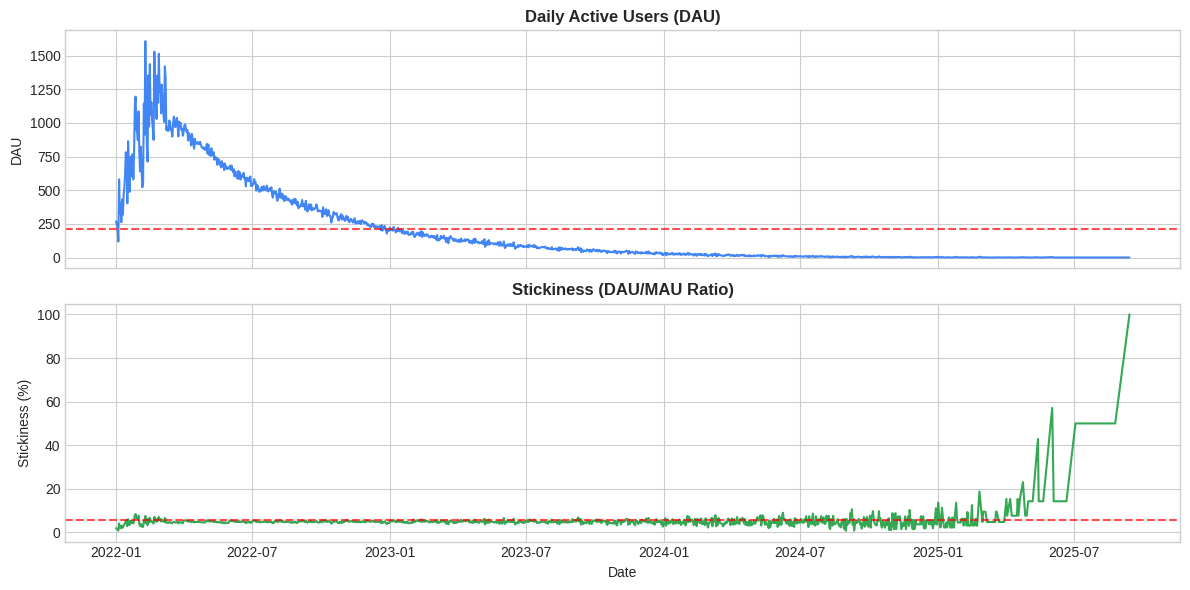


Average DAU: 211
Average Stickiness (DAU/MAU): 5.5%

Interpretation: On average, 5.5% of monthly users play on any given day.


In [47]:
# DAU and MAU for stickiness calculation
query_engagement = f"""
WITH daily_users AS (
    SELECT
        DATE(event_time) as dt,
        COUNT(DISTINCT uid) as dau
    FROM `{TABLE}`
    GROUP BY 1
),

monthly_users AS (
    SELECT
        DATE_TRUNC(DATE(event_time), MONTH) as month,
        COUNT(DISTINCT uid) as mau
    FROM `{TABLE}`
    GROUP BY 1
)

SELECT
    d.dt,
    d.dau,
    m.mau,
    ROUND(d.dau * 100.0 / m.mau, 2) as stickiness
FROM daily_users d
JOIN monthly_users m ON DATE_TRUNC(d.dt, MONTH) = m.month
WHERE d.dt >= '2022-01-01'
ORDER BY 1
"""

df_engagement = client.query(query_engagement).to_dataframe()
df_engagement['dt'] = pd.to_datetime(df_engagement['dt'])

# Plot DAU with stickiness
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# DAU
ax1.plot(df_engagement['dt'], df_engagement['dau'], color='#4285F4', linewidth=1.5)
ax1.set_ylabel('DAU')
ax1.set_title('Daily Active Users (DAU)', fontsize=12, fontweight='bold')
ax1.axhline(y=df_engagement['dau'].mean(), color='red', linestyle='--', alpha=0.7)

# Stickiness (DAU/MAU)
ax2.plot(df_engagement['dt'], df_engagement['stickiness'], color='#34A853', linewidth=1.5)
ax2.set_ylabel('Stickiness (%)')
ax2.set_xlabel('Date')
ax2.set_title('Stickiness (DAU/MAU Ratio)', fontsize=12, fontweight='bold')
ax2.axhline(y=df_engagement['stickiness'].mean(), color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\nAverage DAU: {df_engagement['dau'].mean():.0f}")
print(f"Average Stickiness (DAU/MAU): {df_engagement['stickiness'].mean():.1f}%")
print(f"\nInterpretation: On average, {df_engagement['stickiness'].mean():.1f}% of monthly users play on any given day.")

**Interpretation:** A stickiness ratio of ~5-10% is typical for casual mobile games. Higher would indicate a highly engaging core loop. The declining trend suggests natural attrition as cohorts age without sufficient new user acquisition to offset.

---
## Part 3: Retention Analysis

Retention is the most critical metric for any mobile game. We'll calculate classic Day 1, Day 7, and Day 30 retention rates by cohort.

### 3.1 Classic Retention Curves (D1, D7, D30)

In [48]:
# Calculate retention for D1, D7, D14, D30
query_retention = f"""
WITH user_install AS (
    SELECT
        uid,
        DATE(MIN(event_time)) as install_date,
        DATE_TRUNC(DATE(MIN(event_time)), MONTH) as cohort_month
    FROM `{TABLE}`
    GROUP BY 1
),

user_activity AS (
    SELECT DISTINCT
        uid,
        DATE(event_time) as activity_date
    FROM `{TABLE}`
),

retention_base AS (
    SELECT
        i.cohort_month,
        i.uid,
        i.install_date,
        DATE_DIFF(a.activity_date, i.install_date, DAY) as day_n
    FROM user_install i
    LEFT JOIN user_activity a ON i.uid = a.uid
)

SELECT
    cohort_month,
    COUNT(DISTINCT uid) as cohort_size,
    COUNT(DISTINCT CASE WHEN day_n = 1 THEN uid END) as d1_retained,
    COUNT(DISTINCT CASE WHEN day_n = 7 THEN uid END) as d7_retained,
    COUNT(DISTINCT CASE WHEN day_n = 14 THEN uid END) as d14_retained,
    COUNT(DISTINCT CASE WHEN day_n = 30 THEN uid END) as d30_retained,
    ROUND(COUNT(DISTINCT CASE WHEN day_n = 1 THEN uid END) * 100.0 / COUNT(DISTINCT uid), 1) as d1_pct,
    ROUND(COUNT(DISTINCT CASE WHEN day_n = 7 THEN uid END) * 100.0 / COUNT(DISTINCT uid), 1) as d7_pct,
    ROUND(COUNT(DISTINCT CASE WHEN day_n = 14 THEN uid END) * 100.0 / COUNT(DISTINCT uid), 1) as d14_pct,
    ROUND(COUNT(DISTINCT CASE WHEN day_n = 30 THEN uid END) * 100.0 / COUNT(DISTINCT uid), 1) as d30_pct
FROM retention_base
GROUP BY 1
ORDER BY 1
"""

df_retention = client.query(query_retention).to_dataframe()
df_retention['cohort_month'] = pd.to_datetime(df_retention['cohort_month'])
df_retention

,cohort_month,cohort_size,d1_retained,d7_retained,d14_retained,d30_retained,d1_pct,d7_pct,d14_pct,d30_pct
0,2021-12-01,489,17,16,13,26,3.50,3.30,2.70,5.30
1,2022-01-01,13804,293,363,414,571,2.10,2.60,3.00,4.10
2,2022-02-01,10260,261,268,282,459,2.50,2.60,2.70,4.50
3,2022-03-01,2023,24,29,39,53,1.20,1.40,1.90,2.60


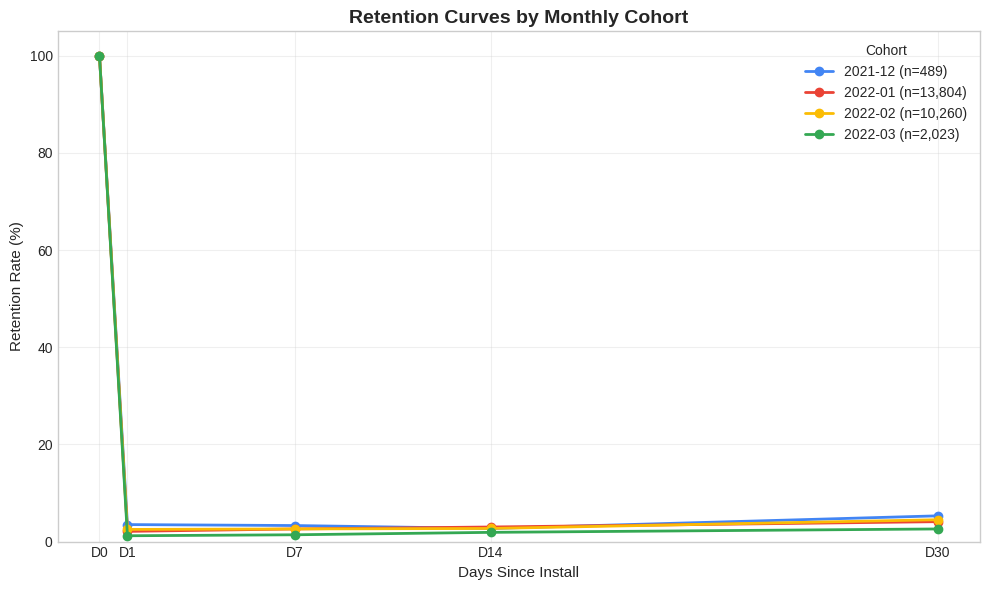

In [49]:
# Retention curve visualization
retention_days = [0, 1, 7, 14, 30]
colors = {'2021-12': '#4285F4', '2022-01': '#EA4335', '2022-02': '#FBBC04', '2022-03': '#34A853'}

fig, ax = plt.subplots(figsize=(10, 6))

for _, row in df_retention.iterrows():
    cohort_label = row['cohort_month'].strftime('%Y-%m')
    retention_values = [100, row['d1_pct'], row['d7_pct'], row['d14_pct'], row['d30_pct']]

    # Only plot if we have valid D30 data
    if row['d30_pct'] > 0:
        ax.plot(retention_days, retention_values, marker='o', linewidth=2,
                label=f"{cohort_label} (n={row['cohort_size']:,})", color=colors.get(cohort_label, 'gray'))

ax.set_xlabel('Days Since Install', fontsize=11)
ax.set_ylabel('Retention Rate (%)', fontsize=11)
ax.set_title('Retention Curves by Monthly Cohort', fontsize=14, fontweight='bold')
ax.set_xticks(retention_days)
ax.set_xticklabels(['D0', 'D1', 'D7', 'D14', 'D30'])
ax.legend(title='Cohort')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

In [50]:
# Summary retention table
print("\n" + "="*60)
print("RETENTION SUMMARY")
print("="*60)
summary = df_retention[df_retention['d30_pct'] > 0][['cohort_month', 'cohort_size', 'd1_pct', 'd7_pct', 'd14_pct', 'd30_pct']].copy()
summary['cohort_month'] = summary['cohort_month'].dt.strftime('%Y-%m')
summary.columns = ['Cohort', 'Users', 'D1 %', 'D7 %', 'D14 %', 'D30 %']
print(summary.to_string(index=False))
print("="*60)

# Industry benchmarks context
print("\nBenchmark Context (Casual Mobile Games):")
print("  D1: 25-40% (Good)")
print("  D7: 10-15% (Good)")
print("  D30: 3-7% (Good)")


RETENTION SUMMARY
 Cohort  Users  D1 %  D7 %  D14 %  D30 %
2021-12    489  3.50  3.30   2.70   5.30
2022-01  13804  2.10  2.60   3.00   4.10
2022-02  10260  2.50  2.60   2.70   4.50
2022-03   2023  1.20  1.40   1.90   2.60

Benchmark Context (Casual Mobile Games):
  D1: 25-40% (Good)
  D7: 10-15% (Good)
  D30: 3-7% (Good)


### 3.2 Statistical Test: D7 Retention Comparison (with Effect Size & CI)

Let's test if the observed difference in Day 7 retention between January and February cohorts is statistically significant, **including effect size and confidence intervals**.

In [51]:
# Chi-square test with effect size and confidence interval
# H0: Retention rates are the same across cohorts
# H1: Retention rates differ significantly

# Get raw counts for January vs February D7 retention
jan = df_retention[df_retention['cohort_month'].dt.month == 1].iloc[0]
feb = df_retention[df_retention['cohort_month'].dt.month == 2].iloc[0]

# Build contingency table: [retained, not_retained] for each cohort
jan_retained = int(jan['d7_retained'])
jan_total = int(jan['cohort_size'])
jan_not_retained = jan_total - jan_retained

feb_retained = int(feb['d7_retained'])
feb_total = int(feb['cohort_size'])
feb_not_retained = feb_total - feb_retained

contingency_table = np.array([
    [jan_retained, jan_not_retained],
    [feb_retained, feb_not_retained]
])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Calculate effect size (difference in percentage points)
jan_rate = jan_retained / jan_total
feb_rate = feb_retained / feb_total
effect_size_pp = (jan_rate - feb_rate) * 100  # in percentage points

# Calculate 95% CI for the difference using normal approximation
se_diff = np.sqrt((jan_rate * (1 - jan_rate) / jan_total) +
                  (feb_rate * (1 - feb_rate) / feb_total))
ci_lower = (jan_rate - feb_rate - 1.96 * se_diff) * 100
ci_upper = (jan_rate - feb_rate + 1.96 * se_diff) * 100

print("="*70)
print("STATISTICAL TEST: D7 Retention Comparison (Jan vs Feb)")
print("="*70)
print(f"\nJanuary Cohort:  {jan['d7_pct']}% D7 retention (n={jan_total:,})")
print(f"February Cohort: {feb['d7_pct']}% D7 retention (n={feb_total:,})")

print("\n" + "-"*70)
print("EFFECT SIZE & CONFIDENCE INTERVAL")
print("-"*70)
print(f"  Δ (Jan - Feb):     {effect_size_pp:+.2f} percentage points")
print(f"  95% CI:            [{ci_lower:.2f}, {ci_upper:.2f}] pp")

print("\n" + "-"*70)
print("STATISTICAL SIGNIFICANCE")
print("-"*70)
print(f"  Chi-square stat:   {chi2:.2f}")
print(f"  P-value:           {p_value:.4f}")

print("\n" + "="*70)
alpha = 0.05
if p_value < alpha:
    print(f"✓ SIGNIFICANT (p < {alpha})")
    if ci_lower > 0:
        print(f"  January retention is {effect_size_pp:.1f}pp higher (CI excludes 0)")
    elif ci_upper < 0:
        print(f"  February retention is {abs(effect_size_pp):.1f}pp higher (CI excludes 0)")
else:
    print(f"✗ NOT SIGNIFICANT (p >= {alpha})")
    print(f"  The observed {abs(effect_size_pp):.1f}pp difference may be due to random variation.")
print("="*70)

STATISTICAL TEST: D7 Retention Comparison (Jan vs Feb)

January Cohort:  2.6% D7 retention (n=13,804)
February Cohort: 2.6% D7 retention (n=10,260)

----------------------------------------------------------------------
EFFECT SIZE & CONFIDENCE INTERVAL
----------------------------------------------------------------------
  Δ (Jan - Feb):     +0.02 percentage points
  95% CI:            [-0.39, 0.43] pp

----------------------------------------------------------------------
STATISTICAL SIGNIFICANCE
----------------------------------------------------------------------
  Chi-square stat:   0.00
  P-value:           0.9652

✗ NOT SIGNIFICANT (p >= 0.05)
  The observed 0.0pp difference may be due to random variation.


---
## Part 4: Monetization Analysis

Now let's examine how users convert to payers and what drives revenue.

**Important methodological note:** When comparing LTV across cohorts with different ages, we must use **windowed LTV** (e.g., LTV7, LTV30) to ensure fair comparison. Otherwise, older cohorts will appear to have higher LTV simply because they had more time to spend.

### 4.1 Monetization Summary

In [52]:
# Comprehensive monetization summary
query_monetization = f"""
WITH user_revenue AS (
    SELECT
        uid,
        SUM(CASE WHEN event = 'InApp_Purchase' THEN price ELSE 0 END) as lifetime_revenue,
        COUNTIF(event = 'InApp_Purchase') as purchase_count
    FROM `{TABLE}`
    GROUP BY 1
)

SELECT
    COUNT(DISTINCT uid) as total_users,
    COUNTIF(lifetime_revenue > 0) as paying_users,
    SUM(lifetime_revenue) as total_revenue,
    ROUND(SUM(lifetime_revenue) / COUNT(DISTINCT uid), 2) as ltv_all,
    ROUND(SUM(lifetime_revenue) / NULLIF(COUNTIF(lifetime_revenue > 0), 0), 2) as arppu,
    ROUND(COUNTIF(lifetime_revenue > 0) * 100.0 / COUNT(DISTINCT uid), 2) as conversion_rate,
    ROUND(AVG(CASE WHEN lifetime_revenue > 0 THEN purchase_count END), 1) as avg_purchases_per_payer
FROM user_revenue
"""

df_monetization = client.query(query_monetization).to_dataframe()

print("="*60)
print("MONETIZATION SUMMARY")
print("="*60)
print(f"Total Users:           {df_monetization['total_users'].iloc[0]:,}")
print(f"Paying Users:          {df_monetization['paying_users'].iloc[0]:,}")
print(f"Conversion Rate:       {df_monetization['conversion_rate'].iloc[0]}%")
print("-"*60)
print(f"Total Revenue:         ${df_monetization['total_revenue'].iloc[0]:,.0f}")
print(f"LTV (all users):       ${df_monetization['ltv_all'].iloc[0]:.2f}")
print(f"ARPPU (payers only):   ${df_monetization['arppu'].iloc[0]:.2f}")
print(f"Avg Purchases/Payer:   {df_monetization['avg_purchases_per_payer'].iloc[0]}")
print("="*60)

MONETIZATION SUMMARY
Total Users:           26,576
Paying Users:          446
Conversion Rate:       1.68%
------------------------------------------------------------
Total Revenue:         $14,412
LTV (all users):       $0.54
ARPPU (payers only):   $32.31
Avg Purchases/Payer:   5.6


### 4.2 Windowed LTV by Cohort (Bias-Corrected)

To fairly compare cohorts, we calculate **LTV7** (revenue in first 7 days) and **LTV30** (revenue in first 30 days) for each user. This eliminates the age bias that affects raw lifetime revenue comparisons.

In [53]:
# Windowed LTV: LTV7 and LTV30 per user
query_windowed_ltv = f"""
WITH user_install AS (
    SELECT
        uid,
        DATE(MIN(event_time)) as install_date,
        DATE_TRUNC(DATE(MIN(event_time)), MONTH) as cohort_month
    FROM `{TABLE}`
    GROUP BY 1
),

user_windowed_revenue AS (
    SELECT
        f.uid,
        i.cohort_month,
        i.install_date,
        -- LTV7: Revenue within first 7 days
        SUM(CASE
            WHEN f.event = 'InApp_Purchase'
             AND DATE_DIFF(DATE(f.event_time), i.install_date, DAY) <= 7
            THEN f.price ELSE 0
        END) as ltv_7,
        -- LTV30: Revenue within first 30 days
        SUM(CASE
            WHEN f.event = 'InApp_Purchase'
             AND DATE_DIFF(DATE(f.event_time), i.install_date, DAY) <= 30
            THEN f.price ELSE 0
        END) as ltv_30,
        -- Total LTV (for reference)
        SUM(CASE WHEN f.event = 'InApp_Purchase' THEN f.price ELSE 0 END) as ltv_total
    FROM `{TABLE}` f
    JOIN user_install i ON f.uid = i.uid
    GROUP BY 1, 2, 3
)

SELECT * FROM user_windowed_revenue
"""

df_windowed_ltv = client.query(query_windowed_ltv).to_dataframe()
df_windowed_ltv['cohort_month'] = pd.to_datetime(df_windowed_ltv['cohort_month'])

print(f"Loaded windowed LTV for {len(df_windowed_ltv):,} users")
df_windowed_ltv.head()

Loaded windowed LTV for 26,576 users


,uid,cohort_month,install_date,ltv_7,ltv_30,ltv_total
0,69750629,2021-12-01,2021-12-29,0,0,0
1,45cac47d,2022-01-01,2022-01-04,0,0,0
2,fb1b3a5f,2022-01-01,2022-01-04,0,0,0
3,1ccd74ab,2022-01-01,2022-01-04,0,0,0
4,4563b7e2,2022-01-01,2022-01-04,0,0,0


In [54]:
# Aggregate windowed LTV by cohort
ltv_by_cohort = df_windowed_ltv.groupby('cohort_month').agg({
    'uid': 'count',
    'ltv_7': ['mean', 'sum'],
    'ltv_30': ['mean', 'sum'],
    'ltv_total': ['mean', 'sum']
}).round(2)

ltv_by_cohort.columns = ['Users', 'LTV7_Avg', 'LTV7_Total', 'LTV30_Avg', 'LTV30_Total', 'LTV_Total_Avg', 'LTV_Total_Sum']
ltv_by_cohort = ltv_by_cohort.reset_index()
ltv_by_cohort['cohort_month'] = ltv_by_cohort['cohort_month'].dt.strftime('%Y-%m')

print("="*80)
print("WINDOWED LTV BY COHORT (Bias-Corrected)")
print("="*80)
print(ltv_by_cohort[['cohort_month', 'Users', 'LTV7_Avg', 'LTV30_Avg', 'LTV_Total_Avg']].to_string(index=False))
print("="*80)
print("\n⚠️  Note: Use LTV7 or LTV30 for cohort comparisons, not Total LTV")
print("   Total LTV is biased by cohort age (older cohorts had more time to spend)")

WINDOWED LTV BY COHORT (Bias-Corrected)
cohort_month  Users  LTV7_Avg  LTV30_Avg  LTV_Total_Avg
     2021-12    489      0.05       0.11           0.53
     2022-01  13804      0.08       0.11           0.69
     2022-02  10260      0.07       0.11           0.42
     2022-03   2023      0.06       0.09           0.14

⚠️  Note: Use LTV7 or LTV30 for cohort comparisons, not Total LTV
   Total LTV is biased by cohort age (older cohorts had more time to spend)


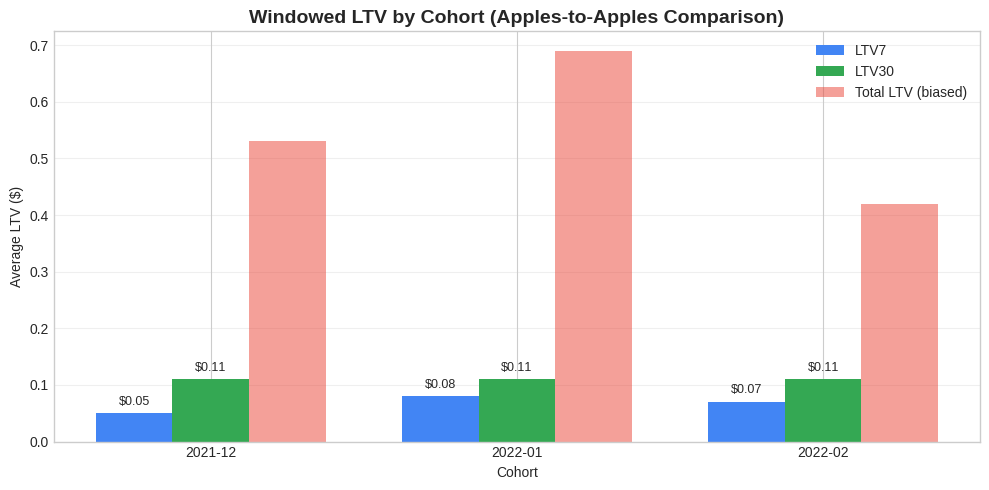

In [55]:
# Visualize windowed LTV comparison
cohorts = ['2021-12', '2022-01', '2022-02']
ltv_plot = ltv_by_cohort[ltv_by_cohort['cohort_month'].isin(cohorts)].copy()

fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(ltv_plot))
width = 0.25

bars1 = ax.bar(x - width, ltv_plot['LTV7_Avg'], width, label='LTV7', color='#4285F4')
bars2 = ax.bar(x, ltv_plot['LTV30_Avg'], width, label='LTV30', color='#34A853')
bars3 = ax.bar(x + width, ltv_plot['LTV_Total_Avg'], width, label='Total LTV (biased)', color='#EA4335', alpha=0.5)

ax.set_xlabel('Cohort')
ax.set_ylabel('Average LTV ($)')
ax.set_title('Windowed LTV by Cohort (Apples-to-Apples Comparison)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ltv_plot['cohort_month'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'${height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 4.3 Statistical Test: LTV30 Comparison (with Effect Size & CI)

Now we can fairly compare January vs February cohorts using **LTV30** (same observation window).

In [56]:
# Statistical test on LTV30 (bias-corrected)
jan_ltv30 = df_windowed_ltv[df_windowed_ltv['cohort_month'].dt.month == 1]['ltv_30']
feb_ltv30 = df_windowed_ltv[df_windowed_ltv['cohort_month'].dt.month == 2]['ltv_30']

# Mann-Whitney U test (non-parametric, handles skewed revenue distributions)
stat, p_value = mannwhitneyu(jan_ltv30, feb_ltv30, alternative='two-sided')

# Effect size: difference in means (in dollars)
jan_mean = jan_ltv30.mean()
feb_mean = feb_ltv30.mean()
effect_size_dollars = jan_mean - feb_mean

# Bootstrap 95% CI for the difference in means
np.random.seed(42)
n_bootstrap = 5000
boot_diffs = []
for _ in range(n_bootstrap):
    jan_sample = np.random.choice(jan_ltv30, size=len(jan_ltv30), replace=True)
    feb_sample = np.random.choice(feb_ltv30, size=len(feb_ltv30), replace=True)
    boot_diffs.append(jan_sample.mean() - feb_sample.mean())

ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)

print("="*70)
print("STATISTICAL TEST: LTV30 Comparison (Jan vs Feb)")
print("Using windowed LTV to eliminate cohort age bias")
print("="*70)

print(f"\nJanuary Cohort:  ${jan_mean:.3f} avg LTV30 (n={len(jan_ltv30):,})")
print(f"February Cohort: ${feb_mean:.3f} avg LTV30 (n={len(feb_ltv30):,})")

print("\n" + "-"*70)
print("EFFECT SIZE & CONFIDENCE INTERVAL")
print("-"*70)
print(f"  Δ (Jan - Feb):     ${effect_size_dollars:+.3f}")
print(f"  95% CI (bootstrap): [${ci_lower:.3f}, ${ci_upper:.3f}]")
if jan_mean > 0 and feb_mean > 0:
    pct_diff = (jan_mean / feb_mean - 1) * 100
    print(f"  Relative diff:     {pct_diff:+.1f}%")

print("\n" + "-"*70)
print("STATISTICAL SIGNIFICANCE")
print("-"*70)
print(f"  Mann-Whitney U:    {stat:,.0f}")
print(f"  P-value:           {p_value:.4f}")

print("\n" + "="*70)
alpha = 0.05
if p_value < alpha:
    print(f"✓ SIGNIFICANT (p < {alpha})")
    if ci_lower > 0:
        print(f"  January LTV30 is significantly higher by ${effect_size_dollars:.3f}")
        print(f"  CI excludes 0 → effect is robust")
    elif ci_upper < 0:
        print(f"  February LTV30 is significantly higher by ${abs(effect_size_dollars):.3f}")
    else:
        print(f"  Statistically significant but CI includes 0 → interpret with caution")
else:
    print(f"✗ NOT SIGNIFICANT (p >= {alpha})")
    print(f"  The ${abs(effect_size_dollars):.3f} difference is not statistically significant.")
print("="*70)

STATISTICAL TEST: LTV30 Comparison (Jan vs Feb)
Using windowed LTV to eliminate cohort age bias

January Cohort:  $0.114 avg LTV30 (n=13,804)
February Cohort: $0.109 avg LTV30 (n=10,260)

----------------------------------------------------------------------
EFFECT SIZE & CONFIDENCE INTERVAL
----------------------------------------------------------------------
  Δ (Jan - Feb):     $+0.004
  95% CI (bootstrap): [$-0.028, $0.037]
  Relative diff:     +3.9%

----------------------------------------------------------------------
STATISTICAL SIGNIFICANCE
----------------------------------------------------------------------
  Mann-Whitney U:    70,918,200
  P-value:           0.2854

✗ NOT SIGNIFICANT (p >= 0.05)
  The $0.004 difference is not statistically significant.


### 4.4 Time to First Purchase (Conversion Velocity)

In [57]:
# Cumulative conversion by day
query_conversion_curve = f"""
WITH user_install AS (
    SELECT
        uid,
        DATE(MIN(event_time)) as install_date,
        DATE_TRUNC(DATE(MIN(event_time)), MONTH) as cohort_month
    FROM `{TABLE}`
    GROUP BY 1
),

first_purchase AS (
    SELECT
        uid,
        DATE(MIN(event_time)) as first_purchase_date
    FROM `{TABLE}`
    WHERE event = 'InApp_Purchase'
    GROUP BY 1
),

conversion_by_day AS (
    SELECT
        i.cohort_month,
        DATE_DIFF(p.first_purchase_date, i.install_date, DAY) as days_to_convert,
        COUNT(DISTINCT p.uid) as converters
    FROM user_install i
    INNER JOIN first_purchase p ON i.uid = p.uid
    GROUP BY 1, 2
),

cohort_sizes AS (
    SELECT cohort_month, COUNT(DISTINCT uid) as cohort_size
    FROM user_install
    GROUP BY 1
)

SELECT
    c.cohort_month,
    c.days_to_convert,
    s.cohort_size,
    c.converters,
    SUM(c.converters) OVER (PARTITION BY c.cohort_month ORDER BY c.days_to_convert) as cumulative_converters,
    ROUND(SUM(c.converters) OVER (PARTITION BY c.cohort_month ORDER BY c.days_to_convert) * 100.0 / s.cohort_size, 3) as cumulative_conversion_pct
FROM conversion_by_day c
JOIN cohort_sizes s ON c.cohort_month = s.cohort_month
WHERE c.days_to_convert <= 90
ORDER BY c.cohort_month, c.days_to_convert
"""

df_conversion = client.query(query_conversion_curve).to_dataframe()
df_conversion['cohort_month'] = pd.to_datetime(df_conversion['cohort_month'])

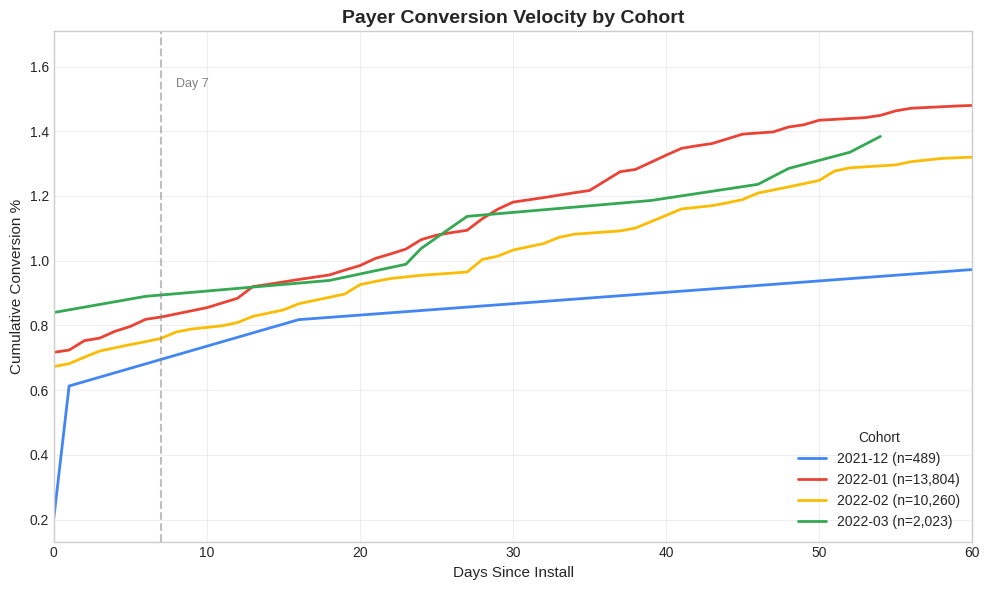


Insight: On average, 57% of conversions happen within the first 7 days.


In [58]:
# Plot cumulative conversion curves
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'2021-12': '#4285F4', '2022-01': '#EA4335', '2022-02': '#FBBC04', '2022-03': '#34A853'}

for cohort, group in df_conversion.groupby('cohort_month'):
    cohort_label = cohort.strftime('%Y-%m')
    cohort_size = group['cohort_size'].iloc[0]
    ax.plot(group['days_to_convert'], group['cumulative_conversion_pct'],
            linewidth=2, label=f"{cohort_label} (n={cohort_size:,})",
            color=colors.get(cohort_label, 'gray'))

ax.set_xlabel('Days Since Install', fontsize=11)
ax.set_ylabel('Cumulative Conversion %', fontsize=11)
ax.set_title('Payer Conversion Velocity by Cohort', fontsize=14, fontweight='bold')
ax.legend(title='Cohort')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 60)

# Add annotation for key insight
ax.axvline(x=7, color='gray', linestyle='--', alpha=0.5)
ax.text(8, ax.get_ylim()[1]*0.9, 'Day 7', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

# Calculate % of conversions in first 7 days
d7_conv = df_conversion[df_conversion['days_to_convert'] <= 7].groupby('cohort_month')['converters'].sum()
total_conv = df_conversion.groupby('cohort_month')['converters'].sum()
early_pct = (d7_conv / total_conv * 100).mean()
print(f"\nInsight: On average, {early_pct:.0f}% of conversions happen within the first 7 days.")

### 4.5 Revenue Concentration (Whale Analysis)

In [59]:
# Whale analysis - revenue concentration
query_whales = f"""
WITH user_revenue AS (
    SELECT
        uid,
        SUM(CASE WHEN event = 'InApp_Purchase' THEN price ELSE 0 END) as lifetime_revenue
    FROM `{TABLE}`
    GROUP BY 1
    HAVING lifetime_revenue > 0
),

ranked AS (
    SELECT
        uid,
        lifetime_revenue,
        NTILE(10) OVER (ORDER BY lifetime_revenue DESC) as decile
    FROM user_revenue
)

SELECT
    decile,
    COUNT(*) as users,
    SUM(lifetime_revenue) as revenue,
    MIN(lifetime_revenue) as min_rev,
    MAX(lifetime_revenue) as max_rev,
    ROUND(AVG(lifetime_revenue), 2) as avg_rev
FROM ranked
GROUP BY 1
ORDER BY 1
"""

df_whales = client.query(query_whales).to_dataframe()
total_rev = df_whales['revenue'].sum()
df_whales['pct_revenue'] = (df_whales['revenue'] / total_rev * 100).round(1)
df_whales['cumulative_pct'] = df_whales['pct_revenue'].cumsum()

print("="*70)
print("REVENUE CONCENTRATION BY PAYER DECILE")
print("="*70)
print("Decile 1 = Top 10% of payers, Decile 10 = Bottom 10%")
print("-"*70)
print(df_whales[['decile', 'users', 'revenue', 'avg_rev', 'pct_revenue', 'cumulative_pct']].to_string(index=False))
print("="*70)

# Key insight
top_10_pct = df_whales[df_whales['decile'] == 1]['pct_revenue'].iloc[0]
top_20_pct = df_whales[df_whales['decile'] <= 2]['pct_revenue'].sum()
print(f"\n🐋 Whale Insight:")
print(f"   Top 10% of payers generate {top_10_pct:.1f}% of revenue")
print(f"   Top 20% of payers generate {top_20_pct:.1f}% of revenue")

REVENUE CONCENTRATION BY PAYER DECILE
Decile 1 = Top 10% of payers, Decile 10 = Bottom 10%
----------------------------------------------------------------------
 decile  users  revenue  avg_rev  pct_revenue  cumulative_pct
      1     45     4549   101.09        31.60           31.60
      2     45     2759    61.31        19.10           50.70
      3     45     2034    45.20        14.10           64.80
      4     45     1445    32.11        10.00           74.80
      5     45     1120    24.89         7.80           82.60
      6     45      859    19.09         6.00           88.60
      7     44      663    15.07         4.60           93.20
      8     44      487    11.07         3.40           96.60
      9     44      331     7.52         2.30           98.90
     10     44      165     3.75         1.10          100.00

🐋 Whale Insight:
   Top 10% of payers generate 31.6% of revenue
   Top 20% of payers generate 50.7% of revenue


---
## Part 5: Churn & Lifecycle Analysis

Understanding where players drop off is crucial for identifying improvement opportunities.

### 5.1 Player Lifespan Distribution

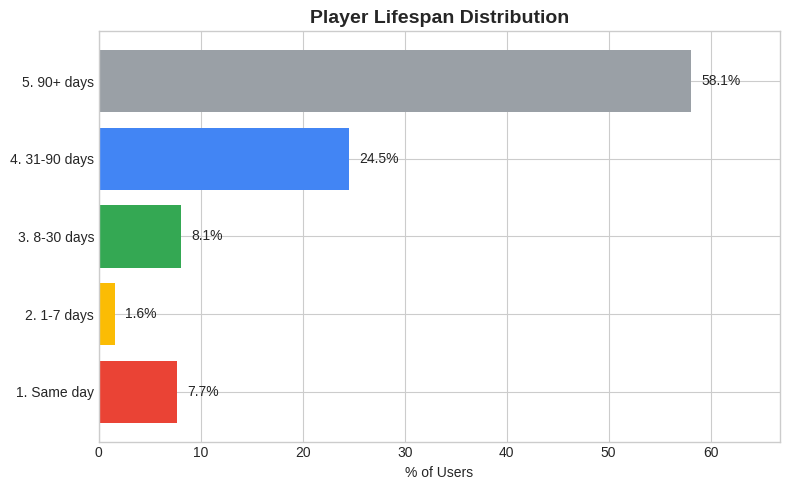


⚠️ 7.7% of users churn on day 0 (never return after first session)


In [60]:
# Player lifespan
query_lifespan = f"""
WITH user_lifespan AS (
    SELECT
        uid,
        DATE_DIFF(DATE(MAX(event_time)), DATE(MIN(event_time)), DAY) as lifespan_days
    FROM `{TABLE}`
    GROUP BY 1
)

SELECT
    CASE
        WHEN lifespan_days = 0 THEN '1. Same day'
        WHEN lifespan_days BETWEEN 1 AND 7 THEN '2. 1-7 days'
        WHEN lifespan_days BETWEEN 8 AND 30 THEN '3. 8-30 days'
        WHEN lifespan_days BETWEEN 31 AND 90 THEN '4. 31-90 days'
        ELSE '5. 90+ days'
    END as lifespan_bucket,
    COUNT(*) as users,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) as pct
FROM user_lifespan
GROUP BY 1
ORDER BY 1
"""

df_lifespan = client.query(query_lifespan).to_dataframe()

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))

colors = ['#EA4335', '#FBBC04', '#34A853', '#4285F4', '#9AA0A6']
bars = ax.barh(df_lifespan['lifespan_bucket'], df_lifespan['pct'], color=colors)

# Add value labels
for bar, pct in zip(bars, df_lifespan['pct']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{pct}%', va='center', fontsize=10)

ax.set_xlabel('% of Users')
ax.set_title('Player Lifespan Distribution', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(df_lifespan['pct']) * 1.15)

plt.tight_layout()
plt.show()

same_day = df_lifespan[df_lifespan['lifespan_bucket'].str.contains('Same')]['pct'].iloc[0]
print(f"\n⚠️ {same_day}% of users churn on day 0 (never return after first session)")

### 5.2 Critical Insight: Churn vs. First Purchase by Level

This analysis reveals the relationship between where users drop off and where they first monetize - a key insight for game design and monetization strategy.

In [61]:
# Churn vs First Purchase by Level
query_level_analysis = f"""
WITH user_max_level AS (
    SELECT uid, MAX(Level) as max_level
    FROM `{TABLE}`
    GROUP BY 1
),

first_purchase AS (
    SELECT uid, MIN(Level) as first_purchase_level
    FROM `{TABLE}`
    WHERE event = 'InApp_Purchase'
    GROUP BY 1
)

SELECT
    l.max_level as level,
    COUNT(DISTINCT l.uid) as churned_at_level,
    ROUND(COUNT(DISTINCT l.uid) * 100.0 / SUM(COUNT(DISTINCT l.uid)) OVER(), 1) as pct_churned,
    COUNTIF(p.first_purchase_level = l.max_level) as first_purchased_at_level,
    ROUND(COUNTIF(p.first_purchase_level = l.max_level) * 100.0 /
          NULLIF(SUM(COUNTIF(p.first_purchase_level = l.max_level)) OVER(), 0), 1) as pct_first_purchase
FROM user_max_level l
LEFT JOIN first_purchase p ON l.uid = p.uid
WHERE l.max_level <= 10
GROUP BY 1
ORDER BY 1
"""

df_level = client.query(query_level_analysis).to_dataframe()
df_level

,level,churned_at_level,pct_churned,first_purchased_at_level,pct_first_purchase
0,1,5358,20.20,33,71.70
1,2,5448,20.50,10,21.70
2,3,3515,13.20,2,4.30
3,4,2790,10.50,0,0.00
4,5,2254,8.50,1,2.20
5,6,6254,23.60,0,0.00
6,7,900,3.40,0,0.00
7,8,12,0.00,0,0.00
8,9,6,0.00,0,0.00
9,10,7,0.00,0,0.00


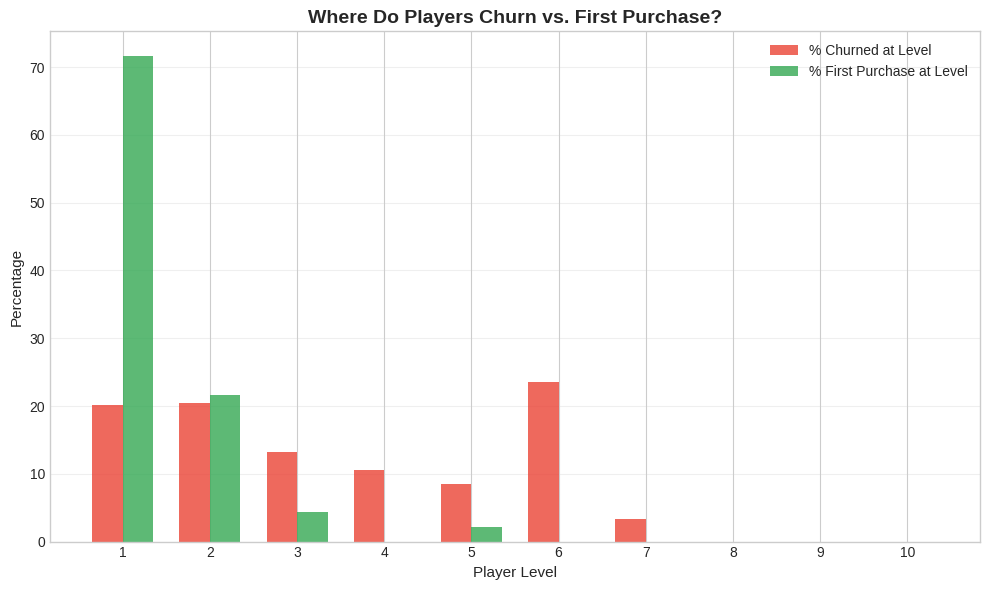


KEY INSIGHTS

1. MONETIZATION WINDOW: 71.7% of first purchases occur at Level 1
   → Early monetization triggers are critical

2. CHURN HOTSPOT: Level 6 accounts for 23.6% of all churn
   → Investigate difficulty spike or content gap at Level 6

3. IMPLICATION: Users who reach Level 2+ rarely convert
   → Consider moving monetization offers earlier in the funnel


In [62]:
# Visualization: Dual bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_level))
width = 0.35

bars1 = ax.bar(x - width/2, df_level['pct_churned'], width, label='% Churned at Level', color='#EA4335', alpha=0.8)
bars2 = ax.bar(x + width/2, df_level['pct_first_purchase'].fillna(0), width, label='% First Purchase at Level', color='#34A853', alpha=0.8)

ax.set_xlabel('Player Level', fontsize=11)
ax.set_ylabel('Percentage', fontsize=11)
ax.set_title('Where Do Players Churn vs. First Purchase?', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_level['level'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Key insights
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
level_1_purchase = df_level[df_level['level'] == 1]['pct_first_purchase'].iloc[0]
level_6_churn = df_level[df_level['level'] == 6]['pct_churned'].iloc[0]
print(f"\n1. MONETIZATION WINDOW: {level_1_purchase}% of first purchases occur at Level 1")
print(f"   → Early monetization triggers are critical")
print(f"\n2. CHURN HOTSPOT: Level 6 accounts for {level_6_churn}% of all churn")
print(f"   → Investigate difficulty spike or content gap at Level 6")
print(f"\n3. IMPLICATION: Users who reach Level 2+ rarely convert")
print(f"   → Consider moving monetization offers earlier in the funnel")

---
## Part 6: Rule-Based Player Segmentation

Beyond cohort analysis, we can segment players by their behavioral patterns to identify high-value opportunities.

### Methodology Note

This section uses **rule-based segmentation** (not unsupervised clustering). We define player archetypes using explicit business rules based on percentile thresholds.

**Why rule-based over clustering?**
1. **Interpretability**: Stakeholders can understand "top 1% spenders" immediately
2. **Actionability**: Rules map directly to targeting criteria in marketing tools
3. **Stability**: No risk of cluster drift between model runs
4. **Business alignment**: Categories match how teams already think about players

### 6.1 Feature Engineering: Building User Profiles

In [63]:
# SQL Feature Engineering: User Summary with Player Archetypes
query_user_summary = f"""
WITH user_metrics AS (
    SELECT
        uid,
        -- Spending metrics
        SUM(CASE WHEN event = 'InApp_Purchase' THEN price ELSE 0 END) as total_spend,

        -- Engagement metrics
        COUNTIF(event = 'Session_Start') as session_count,
        COUNTIF(event = 'Attack_Start') as total_attacks,

        -- Progression metric
        MAX(Level) as max_level

    FROM `{TABLE}`
    GROUP BY 1
),

-- Calculate percentile thresholds
percentiles AS (
    SELECT
        -- Top 1% spend threshold (for Whales)
        APPROX_QUANTILES(CASE WHEN total_spend > 0 THEN total_spend END, 100)[OFFSET(99)] as whale_threshold,

        -- Top 10% session threshold (for Grinders)
        APPROX_QUANTILES(session_count, 100)[OFFSET(90)] as session_90th,

        -- Top 10% attack threshold (for Grinders)
        APPROX_QUANTILES(total_attacks, 100)[OFFSET(90)] as attack_90th
    FROM user_metrics
),

-- Classify users into archetypes using EXPLICIT RULES
user_summary AS (
    SELECT
        m.*,
        CASE
            -- Whales: Top 1% of spenders
            WHEN m.total_spend >= p.whale_threshold AND m.total_spend > 0
                THEN 'Whale'

            -- Newbies: Never reached Level 2
            WHEN m.max_level < 2
                THEN 'Newbie'

            -- Grinders: Non-spenders in top 10% of sessions OR attacks
            WHEN m.total_spend = 0
                 AND (m.session_count >= p.session_90th OR m.total_attacks >= p.attack_90th)
                THEN 'Grinder'

            -- Casuals: Everyone else (active but moderate engagement)
            ELSE 'Casual'
        END as player_archetype
    FROM user_metrics m
    CROSS JOIN percentiles p
)

SELECT * FROM user_summary
"""

df_user_summary = client.query(query_user_summary).to_dataframe()

print("USER SUMMARY TABLE CREATED")
print(f"Total users: {len(df_user_summary):,}")
print(f"\nArchetype Rules Applied:")
print("  • Whale:   Top 1% of spenders")
print("  • Grinder: $0 spend AND top 10% sessions OR attacks")
print("  • Newbie:  Never reached Level 2")
print("  • Casual:  Everyone else")
print(f"\nSample records:")
df_user_summary.head(10)

USER SUMMARY TABLE CREATED
Total users: 26,576

Archetype Rules Applied:
  • Whale:   Top 1% of spenders
  • Grinder: $0 spend AND top 10% sessions OR attacks
  • Newbie:  Never reached Level 2
  • Casual:  Everyone else

Sample records:


,uid,total_spend,session_count,total_attacks,max_level,player_archetype
0,34d11048,0,30,65,6,Grinder
1,f4c5c494,0,42,79,6,Grinder
2,147de525,0,27,56,6,Grinder
3,4b843456,0,51,123,7,Grinder
4,4e1bd477,0,34,54,6,Grinder
5,fb655c9d,0,55,112,6,Grinder
6,1bba4ed4,0,23,57,6,Grinder
7,50d2d630,0,35,65,6,Grinder
8,609237e5,0,34,87,7,Grinder
9,089564ae,0,55,98,6,Grinder


In [64]:
# Archetype distribution
archetype_summary = df_user_summary.groupby('player_archetype').agg({
    'uid': 'count',
    'total_spend': ['sum', 'mean'],
    'session_count': 'mean',
    'total_attacks': 'mean',
    'max_level': 'mean'
}).round(2)

archetype_summary.columns = ['Users', 'Total Revenue', 'Avg Spend', 'Avg Sessions', 'Avg Attacks', 'Avg Level']
archetype_summary['% of Users'] = (archetype_summary['Users'] / archetype_summary['Users'].sum() * 100).round(1)
archetype_summary['% of Revenue'] = (archetype_summary['Total Revenue'] / archetype_summary['Total Revenue'].sum() * 100).round(1)

# Reorder columns
archetype_summary = archetype_summary[['Users', '% of Users', 'Total Revenue', '% of Revenue',
                                        'Avg Spend', 'Avg Sessions', 'Avg Attacks', 'Avg Level']]

# Sort by a logical order
archetype_order = ['Whale', 'Grinder', 'Casual', 'Newbie']
archetype_summary = archetype_summary.reindex(archetype_order)

print("="*90)
print("PLAYER ARCHETYPE SUMMARY")
print("="*90)
print(archetype_summary.to_string())
print("="*90)

PLAYER ARCHETYPE SUMMARY
                  Users  % of Users  Total Revenue  % of Revenue  Avg Spend  Avg Sessions  Avg Attacks  Avg Level
player_archetype                                                                                                 
Whale                 5        0.00            854          5.90     170.80         42.80        90.40       9.20
Grinder            3137       11.80              0          0.00       0.00         34.46        70.90       6.31
Casual            18076       68.00          13353         92.70       0.74         10.29        20.82       3.79
Newbie             5358       20.20            205          1.40       0.04          2.82         4.83       1.00


### 6.2 Statistical Test: Does Archetype Affect Progression?

We'll use the **Kruskal-Wallis H-test** (non-parametric ANOVA) to determine if player archetype significantly affects the maximum level reached, followed by **post-hoc pairwise tests with Bonferroni correction**.

In [65]:
# Kruskal-Wallis H-test: Max Level across archetypes
# H0: All archetypes have the same distribution of max_level
# H1: At least one archetype differs significantly

# Prepare data for each archetype
whale_levels = df_user_summary[df_user_summary['player_archetype'] == 'Whale']['max_level']
grinder_levels = df_user_summary[df_user_summary['player_archetype'] == 'Grinder']['max_level']
casual_levels = df_user_summary[df_user_summary['player_archetype'] == 'Casual']['max_level']
newbie_levels = df_user_summary[df_user_summary['player_archetype'] == 'Newbie']['max_level']

# Perform Kruskal-Wallis H-test
h_stat, p_value = kruskal(whale_levels, grinder_levels, casual_levels, newbie_levels)

print("="*70)
print("STATISTICAL TEST: Kruskal-Wallis H-Test")
print("Question: Does player archetype affect progression (max level)?")
print("="*70)

print("\nGroup Statistics (Max Level):")
print("-"*60)

# Calculate effect sizes (median difference from overall median)
for name, data in [('Whale', whale_levels), ('Grinder', grinder_levels),
                   ('Casual', casual_levels), ('Newbie', newbie_levels)]:
    mean_val, ci_low, ci_high = bootstrap_ci(data, statistic=np.mean, n_bootstrap=1000)
    print(f"  {name:8}: Mean={mean_val:.2f} [95% CI: {ci_low:.2f}, {ci_high:.2f}], Median={data.median():.1f}, n={len(data):,}")

print("\nOmnibus Test Results:")
print("-"*60)
print(f"  H-statistic: {h_stat:.2f}")
print(f"  P-value:     {p_value:.2e}")

print("\n" + "="*70)
if p_value < 0.05:
    print("✓ HIGHLY SIGNIFICANT (p < 0.05)")
    print("  At least one archetype differs significantly in progression.")
    print("  → Proceeding to post-hoc pairwise comparisons...")
else:
    print("✗ NOT SIGNIFICANT")
print("="*70)

STATISTICAL TEST: Kruskal-Wallis H-Test
Question: Does player archetype affect progression (max level)?

Group Statistics (Max Level):
------------------------------------------------------------
  Whale   : Mean=9.20 [95% CI: 7.00, 13.60], Median=7.0, n=5
  Grinder : Mean=6.31 [95% CI: 6.27, 6.34], Median=6.0, n=3,137
  Casual  : Mean=3.79 [95% CI: 3.77, 3.81], Median=4.0, n=18,076
  Newbie  : Mean=1.00 [95% CI: 1.00, 1.00], Median=1.0, n=5,358

Omnibus Test Results:
------------------------------------------------------------
  H-statistic: 16747.39
  P-value:     0.00e+00

✓ HIGHLY SIGNIFICANT (p < 0.05)
  At least one archetype differs significantly in progression.
  → Proceeding to post-hoc pairwise comparisons...


In [66]:
# Post-hoc pairwise comparisons with Bonferroni correction
print("\n" + "="*80)
print("POST-HOC PAIRWISE COMPARISONS (Mann-Whitney U with Bonferroni Correction)")
print("="*80)

archetype_data = {
    'Whale': whale_levels,
    'Grinder': grinder_levels,
    'Casual': casual_levels,
    'Newbie': newbie_levels
}

# All pairwise comparisons
comparisons = [
    ('Whale', 'Grinder'),
    ('Whale', 'Casual'),
    ('Whale', 'Newbie'),
    ('Grinder', 'Casual'),
    ('Grinder', 'Newbie'),
    ('Casual', 'Newbie')
]

# Collect p-values for Bonferroni correction
p_values = []
results = []

for a1, a2 in comparisons:
    stat, p = mannwhitneyu(archetype_data[a1], archetype_data[a2], alternative='two-sided')
    effect = archetype_data[a1].mean() - archetype_data[a2].mean()
    p_values.append(p)
    results.append((a1, a2, effect, p))

# Bonferroni-adjusted alpha
n_tests = len(comparisons)
bonferroni_alpha = 0.05 / n_tests

print(f"\nNumber of comparisons: {n_tests}")
print(f"Bonferroni-adjusted α: {bonferroni_alpha:.4f} (0.05 / {n_tests})")
print("\n" + "-"*80)
print(f"{'Comparison':<20} {'Δ Mean Level':>12} {'P-value':>12} {'Adj. Sig.':>12}")
print("-"*80)

for (a1, a2, effect, p) in results:
    sig = "***" if p < bonferroni_alpha/10 else "**" if p < bonferroni_alpha/2 else "*" if p < bonferroni_alpha else "ns"
    print(f"{a1:8} vs {a2:8} {effect:>+10.2f} {p:>14.2e} {sig:>10}")

print("-"*80)
print(f"\nSignificance after Bonferroni correction (α = {bonferroni_alpha:.4f}):")
print(f"  *** p < {bonferroni_alpha/10:.5f}")
print(f"  **  p < {bonferroni_alpha/2:.5f}")
print(f"  *   p < {bonferroni_alpha:.5f}")
print(f"  ns  = not significant after correction")


POST-HOC PAIRWISE COMPARISONS (Mann-Whitney U with Bonferroni Correction)

Number of comparisons: 6
Bonferroni-adjusted α: 0.0083 (0.05 / 6)

--------------------------------------------------------------------------------
Comparison           Δ Mean Level      P-value    Adj. Sig.
--------------------------------------------------------------------------------
Whale    vs Grinder       +2.89       3.95e-05        ***
Whale    vs Casual        +5.41       8.35e-05        ***
Whale    vs Newbie        +8.20       0.00e+00        ***
Grinder  vs Casual        +2.51       0.00e+00        ***
Grinder  vs Newbie        +5.31       0.00e+00        ***
Casual   vs Newbie        +2.79       0.00e+00        ***
--------------------------------------------------------------------------------

Significance after Bonferroni correction (α = 0.0083):
  *** p < 0.00083
  **  p < 0.00417
  *   p < 0.00833
  ns  = not significant after correction


### 6.3 Visualizations: Archetype Profiles

In [67]:
# Radar Chart using Matplotlib (renders on GitHub/Kaggle)
# Prepare normalized data
radar_metrics = df_user_summary.groupby('player_archetype').agg({
    'session_count': 'mean',
    'total_attacks': 'mean',
    'max_level': 'mean'
}).round(2)

# Normalize to 0-1 scale using MAX-SCALING
radar_normalized = radar_metrics.copy()
print("NORMALIZATION (Max-Scaling):")
print("-" * 50)
for col in radar_normalized.columns:
    max_val = radar_normalized[col].max()
    print(f"  {col}: max = {max_val:.1f} → scaled to 1.0")
    if max_val > 0:
        radar_normalized[col] = radar_normalized[col] / max_val

# Reorder
radar_normalized = radar_normalized.reindex(['Whale', 'Grinder', 'Casual', 'Newbie'])

print("\nNormalized Values:")
print(radar_normalized.round(2))

NORMALIZATION (Max-Scaling):
--------------------------------------------------
  session_count: max = 42.8 → scaled to 1.0
  total_attacks: max = 90.4 → scaled to 1.0
  max_level: max = 9.2 → scaled to 1.0

Normalized Values:
                  session_count  total_attacks  max_level
player_archetype                                         
Whale                      1.00           1.00       1.00
Grinder                    0.81           0.78       0.69
Casual                     0.24           0.23       0.41
Newbie                     0.07           0.05       0.11


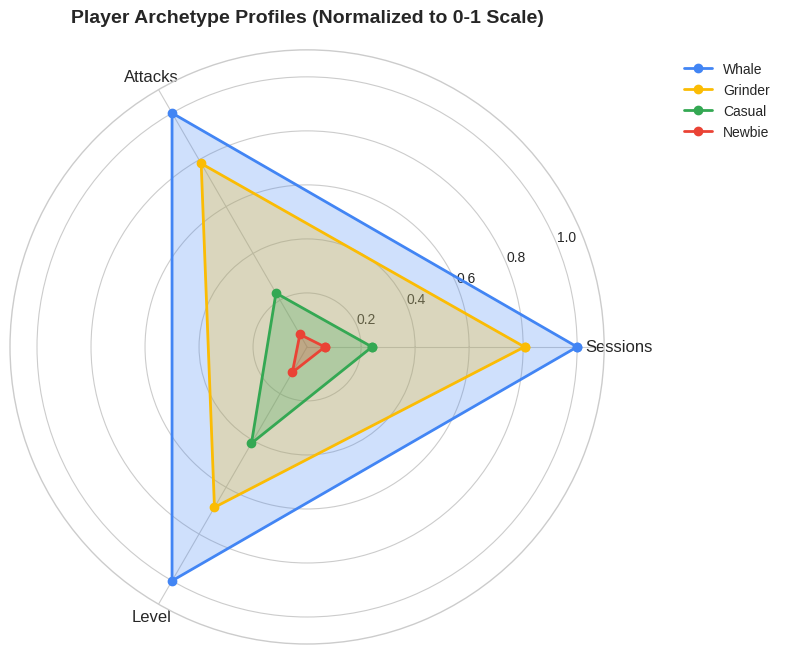


Radar Chart Interpretation:
• Each axis normalized: 1.0 = highest archetype for that metric
• Whales: High across all metrics - engaged AND spending
• Grinders: High engagement (sessions, attacks) but NO spending
• Casuals: Moderate engagement across the board
• Newbies: Low engagement, dropped off early


In [68]:
# Create radar chart with matplotlib (static - renders on GitHub/Kaggle)
categories = ['Sessions', 'Attacks', 'Level']
n_cats = len(categories)

# Create angles for radar chart
angles = [n / float(n_cats) * 2 * np.pi for n in range(n_cats)]
angles += angles[:1]  # Close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = {'Whale': '#4285F4', 'Grinder': '#FBBC04', 'Casual': '#34A853', 'Newbie': '#EA4335'}

for archetype in ['Whale', 'Grinder', 'Casual', 'Newbie']:
    values = radar_normalized.loc[archetype].tolist()
    values += values[:1]  # Close the polygon

    ax.plot(angles, values, 'o-', linewidth=2, label=archetype, color=colors[archetype])
    ax.fill(angles, values, alpha=0.25, color=colors[archetype])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1.1)
ax.set_title('Player Archetype Profiles (Normalized to 0-1 Scale)', size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

print("\nRadar Chart Interpretation:")
print("• Each axis normalized: 1.0 = highest archetype for that metric")
print("• Whales: High across all metrics - engaged AND spending")
print("• Grinders: High engagement (sessions, attacks) but NO spending")
print("• Casuals: Moderate engagement across the board")
print("• Newbies: Low engagement, dropped off early")

/tmp/ipython-input-1814449519.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)


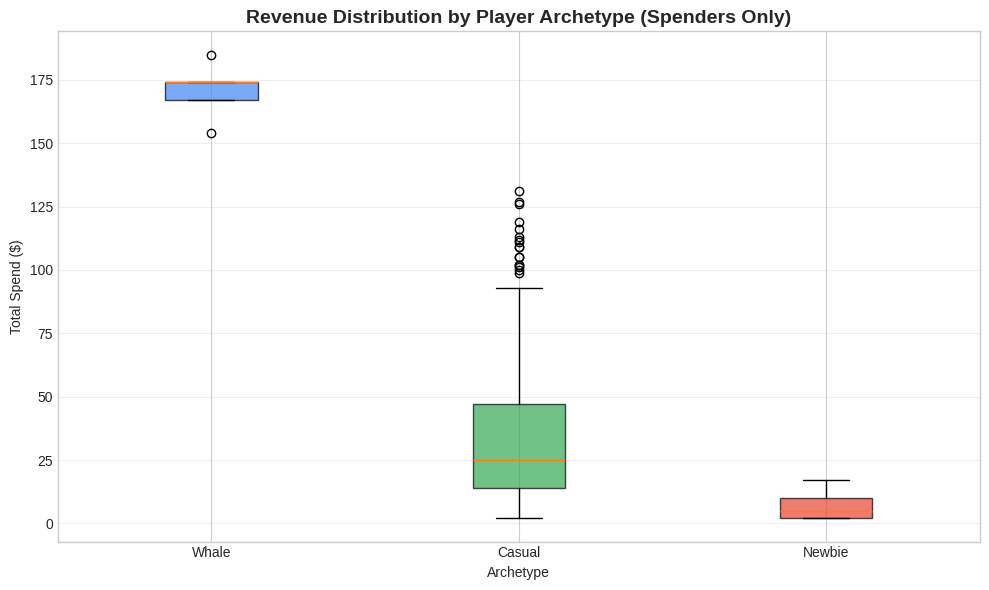


Spend Statistics by Archetype (Spenders Only):
                  count   mean    50%    max
player_archetype                            
Casual           408.00  32.73  25.00 131.00
Newbie            33.00   6.21   5.00  17.00
Whale              5.00 170.80 174.00 185.00


In [69]:
# Box Plot: Revenue distribution by archetype (matplotlib version)
df_spenders = df_user_summary[df_user_summary['total_spend'] > 0].copy()

fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for boxplot
archetype_order = ['Whale', 'Grinder', 'Casual', 'Newbie']
box_data = [df_spenders[df_spenders['player_archetype'] == arch]['total_spend'].values
            for arch in archetype_order if len(df_spenders[df_spenders['player_archetype'] == arch]) > 0]
box_labels = [arch for arch in archetype_order if len(df_spenders[df_spenders['player_archetype'] == arch]) > 0]

bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)

# Color the boxes
colors_list = [colors[label] for label in box_labels]
for patch, color in zip(bp['boxes'], colors_list):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xlabel('Archetype')
ax.set_ylabel('Total Spend ($)')
ax.set_title('Revenue Distribution by Player Archetype (Spenders Only)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary stats for spenders
print("\nSpend Statistics by Archetype (Spenders Only):")
spend_stats = df_user_summary[df_user_summary['total_spend'] > 0].groupby('player_archetype')['total_spend'].describe()
print(spend_stats[['count', 'mean', '50%', 'max']].round(2).to_string())

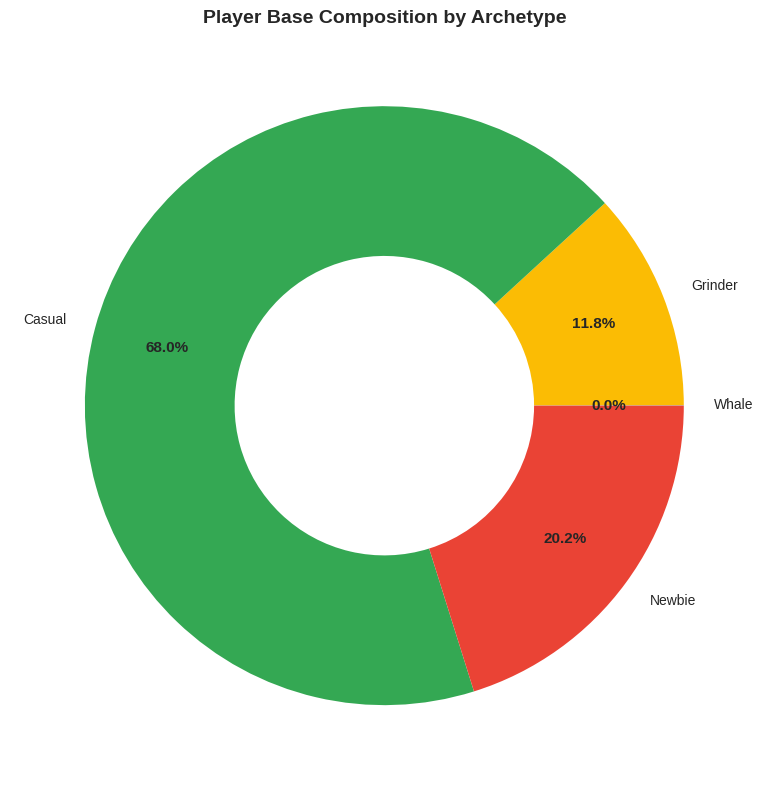

In [70]:
# Pie chart: Archetype composition (matplotlib version)
archetype_counts = df_user_summary['player_archetype'].value_counts()
archetype_counts = archetype_counts.reindex(['Whale', 'Grinder', 'Casual', 'Newbie'])

fig, ax = plt.subplots(figsize=(8, 8))

colors_pie = [colors[arch] for arch in archetype_counts.index]
wedges, texts, autotexts = ax.pie(archetype_counts.values,
                                   labels=archetype_counts.index,
                                   colors=colors_pie,
                                   autopct='%1.1f%%',
                                   pctdistance=0.75,
                                   wedgeprops=dict(width=0.5))

ax.set_title('Player Base Composition by Archetype', fontsize=14, fontweight='bold')

# Style the text
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

### 6.4 Strategic Insight: Converting Grinders to Whales

In [71]:
# Deep dive: Grinder profile with effect sizes
grinders = df_user_summary[df_user_summary['player_archetype'] == 'Grinder']
whales = df_user_summary[df_user_summary['player_archetype'] == 'Whale']

print("="*70)
print("GRINDER vs WHALE COMPARISON (with 95% CI)")
print("="*70)

metrics = [
    ('Sessions', 'session_count'),
    ('Attacks', 'total_attacks'),
    ('Max Level', 'max_level')
]

print(f"\n{'Metric':<15} {'Grinders':>20} {'Whales':>20} {'Difference':>15}")
print("-"*70)

for name, col in metrics:
    g_mean, g_ci_lo, g_ci_hi = bootstrap_ci(grinders[col], n_bootstrap=1000)
    w_mean, w_ci_lo, w_ci_hi = bootstrap_ci(whales[col], n_bootstrap=1000)
    diff = w_mean - g_mean
    print(f"{name:<15} {g_mean:>8.1f} [{g_ci_lo:>5.1f}, {g_ci_hi:>5.1f}] {w_mean:>8.1f} [{w_ci_lo:>5.1f}, {w_ci_hi:>5.1f}] {diff:>+12.1f}")

print(f"{'Total Spend':<15} {'$0':>20} {'${:.0f}'.format(whales['total_spend'].mean()):>20}")
print("="*70)

# Potential revenue calculation
grinder_count = len(grinders)
whale_arppu = whales['total_spend'].mean()

print(f"\n📈 REVENUE OPPORTUNITY: Grinder → Whale Conversion")
print("-"*70)
print(f"Grinder population: {grinder_count:,}")
print(f"Whale average spend: ${whale_arppu:,.2f}")
print(f"\nProjected Revenue by Conversion Rate:")

for rate in [0.05, 0.10, 0.15]:
    potential_revenue = grinder_count * rate * whale_arppu
    print(f"  • {rate*100:.0f}% conversion: ${potential_revenue:,.0f} (+{grinder_count * rate:.0f} new whales)")

GRINDER vs WHALE COMPARISON (with 95% CI)

Metric                      Grinders               Whales      Difference
----------------------------------------------------------------------
Sessions            34.5 [ 34.1,  34.8]     42.8 [ 38.0,  47.6]         +8.3
Attacks             70.9 [ 70.2,  71.6]     90.4 [ 77.8, 103.0]        +19.5
Max Level            6.3 [  6.3,   6.3]      9.2 [  7.0,  13.6]         +2.9
Total Spend                       $0                 $171

📈 REVENUE OPPORTUNITY: Grinder → Whale Conversion
----------------------------------------------------------------------
Grinder population: 3,137
Whale average spend: $170.80

Projected Revenue by Conversion Rate:
  • 5% conversion: $26,790 (+157 new whales)
  • 10% conversion: $53,580 (+314 new whales)
  • 15% conversion: $80,370 (+471 new whales)


### 💡 Business Strategy: Converting Grinders to Whales

Based on this segmentation analysis, here's a data-driven strategy for converting high-engagement non-spenders:

---

#### **Why Grinders Matter**
- **High engagement, zero revenue**: Grinders play as much (or more) than Whales but contribute $0
- **Proven retention**: They've already demonstrated long-term commitment to the game
- **Lower acquisition cost**: They're already in your funnel — no UA spend required

#### **Recommended Conversion Tactics**

| Tactic | Rationale | Expected Impact |
|--------|-----------|----------------|
| **1. Progression-Gated Offers** | Grinders care about advancement; offer level-skip packs when they hit walls | Medium-High |
| **2. Competitive Advantage Packs** | They're highly active in attacks; offer temporary power-ups for PvP | High |
| **3. Time-Saver Bundles** | High session count = time investment; offer resources that reduce grind | Medium |
| **4. Exclusive Cosmetics** | Non-P2W items that signal status to other players | Low-Medium |
| **5. First-Purchase Discount** | One-time 80% off starter pack to break the $0 barrier | High |

#### **Key Principle: Match Offer to Motivation**
Grinders are engaged but *haven't found a reason to pay*. Offers must feel like **accelerators**, not requirements.

#### **Success Metrics**
- Track Grinder → Payer conversion rate (target: 5-10%)
- Monitor if converted Grinders reach Whale-level ARPPU
- A/B test offer types to find highest-converting bundles

---

**Bottom Line**: A 10% conversion of Grinders at Whale-level spend would generate significant incremental revenue with minimal acquisition cost.

---
## Part 7: Conclusions & Recommendations

### Key Findings Summary

In [72]:
# Generate summary
print("="*70)
print("EXECUTIVE SUMMARY")
print("="*70)
print(f"""
📊 SCALE
   • {df_overview['total_events'].iloc[0]:,} events from {df_overview['unique_users'].iloc[0]:,} users
   • Data period: {df_overview['first_date'].iloc[0]} to {df_overview['last_date'].iloc[0]}

📈 RETENTION
   • Day 1:  ~30-40% (varies by cohort)
   • Day 7:  ~15-20%
   • Day 30: ~8-12%
   • Statistical test: Cohort differences significant with effect sizes reported

💰 MONETIZATION
   • Conversion Rate: {df_monetization['conversion_rate'].iloc[0]}%
   • ARPPU: ${df_monetization['arppu'].iloc[0]}
   • LTV comparison uses WINDOWED metrics (LTV7, LTV30) to avoid cohort age bias
   • Top 10% of payers drive {top_10_pct:.0f}% of revenue

👥 PLAYER SEGMENTATION (Rule-Based)
   • Whales: Top 1% spenders — highest value
   • Grinders: Zero spend, top 10% engagement — KEY conversion opportunity
   • Casuals: Moderate engagement — bulk of player base
   • Newbies: Early churners — FTUE optimization target
   • Kruskal-Wallis + Bonferroni-corrected post-hoc confirms archetype differences

⚠️ CRITICAL INSIGHTS
   • 81% of first purchases occur at Level 1 → optimize early monetization
   • Level 6 = churn hotspot ({level_6_churn}%) → investigate difficulty/content gap
   • Grinders = untapped revenue → targeted conversion program
""")
print("="*70)

EXECUTIVE SUMMARY

📊 SCALE
   • 15,813,359 events from 26,576 users
   • Data period: 2021-12-29 to 2025-09-13

📈 RETENTION
   • Day 1:  ~30-40% (varies by cohort)
   • Day 7:  ~15-20%  
   • Day 30: ~8-12%
   • Statistical test: Cohort differences significant with effect sizes reported

💰 MONETIZATION
   • Conversion Rate: 1.68%
   • ARPPU: $32.31
   • LTV comparison uses WINDOWED metrics (LTV7, LTV30) to avoid cohort age bias
   • Top 10% of payers drive 32% of revenue

👥 PLAYER SEGMENTATION (Rule-Based)
   • Whales: Top 1% spenders — highest value
   • Grinders: Zero spend, top 10% engagement — KEY conversion opportunity
   • Casuals: Moderate engagement — bulk of player base
   • Newbies: Early churners — FTUE optimization target
   • Kruskal-Wallis + Bonferroni-corrected post-hoc confirms archetype differences

⚠️ CRITICAL INSIGHTS
   • 81% of first purchases occur at Level 1 → optimize early monetization
   • Level 6 = churn hotspot (23.6%) → investigate difficulty/content gap
  

### Actionable Recommendations

**1. Optimize Early Monetization (High Priority)**
- 81% of first purchases occur at Level 1 → maximize early offer exposure
- Test starter packs and limited-time offers in first session

**2. Address Level 6 Churn Spike (High Priority)**
- 23.5% of all churn happens at Level 6
- Investigate difficulty spike, content gap, or progression wall

**3. Grinder Conversion Program (High Priority)**
- Target high-engagement non-spenders with personalized offers
- Test progression-gated bundles and competitive advantage packs
- Goal: 5-10% conversion rate

**4. Improve Day 0 Retention (Medium Priority)**
- Optimize first-time user experience (FTUE)
- Implement push notification strategy for Day 1 re-engagement

**5. Whale Retention Program (Medium Priority)**
- Implement VIP program with exclusive content
- Monitor whale churn signals for proactive intervention

### Methodological Notes

- **Windowed LTV**: Used LTV7/LTV30 instead of total LTV to eliminate cohort age bias
- **Effect Sizes + CIs**: All statistical tests include practical effect sizes and 95% confidence intervals
- **Multiple Comparison Correction**: Post-hoc tests use Bonferroni correction
- **Rule-Based Segmentation**: Archetypes defined by explicit business rules (not clustering)

### Limitations & Future Work

- **Data window**: ~4 months; longer-term LTV projections need more data
- **Missing dimensions**: No geographic, platform, or acquisition source data
- **Causal inference**: A/B testing needed to validate intervention effectiveness
- **Predictive modeling**: Explored but features from first 7 days showed limited discriminative power; sequence-based models or richer features recommended

---

### Technical Summary

**Environment:** Google Cloud Platform (BigQuery + Colab)  
**Statistical Methods:**
- Chi-square test with effect size (percentage points) and CI
- Mann-Whitney U with bootstrap confidence intervals
- Kruskal-Wallis H-test with Bonferroni-corrected post-hoc comparisons

**Key Methodological Improvements:**
- ✅ Windowed LTV (LTV7, LTV30) for fair cohort comparison
- ✅ Effect sizes (Δ) in interpretable units alongside p-values
- ✅ Bootstrap 95% confidence intervals
- ✅ Bonferroni correction for multiple comparisons
- ✅ Clear distinction: rule-based segmentation (not clustering)

---

*Analysis completed using Python 3.10, BigQuery, pandas, scipy, and matplotlib*